In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)

#from markov_device import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import plotnine 
import glob

## Load Simulation Data

In [2]:
def load_simulation(dir_name, model_name='markov-model1', suffix1='sim-staydata', suffix2='sim-logdata'):    
    
    dfs=pd.read_csv(glob.glob('%s/%s-%s*.csv' % (dir_name, model_name, suffix1))[0], index_col=0, header=0, low_memory=False)
    dfs=dfs.loc[dfs['received_reward']!='received_reward']
    dfs = dfs.astype({
        'epoch':'int',
        'm_parameter':'float',
        'received_reward': 'float',
        'state1_stay':'float'})  

    df = pd.read_csv(glob.glob('%s/%s-%s*.csv' % (dir_name, model_name, suffix2))[0], index_col=0, header=0, low_memory=False)
    df=df.loc[df['received_reward']!='received_reward'] 
    df = df.astype({
        'index_bin':'int',
        'm_parameter':'float',
        'received_reward': 'float',
        'optimal_response_sum_prop':'float',
        'received_reward_sum_prop':'float',
        'received_reward_sum_prop':'float',
        'state1_response_time':'float', 
        'state2_response_time':'float'})
    return df, dfs

In [3]:
model1 = "markov-model1"
model2 = "markov-model2"
model3 = "markov-model3"

# df1, df2, df3 = try_simulation_example()
data_dir = '../data/model/test1/'
try:
    df1, df1_state1stay = load_simulation(dir_name=data_dir, model_name=model1)
    df2, df2_state1stay = load_simulation(dir_name=data_dir, model_name=model2)
    df3, df3_state1stay = load_simulation(dir_name=data_dir, model_name=model3)
    
    df31 = df3.loc[df3['m_parameter'] == 0]
    df32 = df3.loc[df3['m_parameter'] != 0]
    df31_state1stay = df3_state1stay.loc[df3_state1stay['m_parameter'] == 0]
    df32_state1stay = df3_state1stay.loc[df3_state1stay['m_parameter'] != 0]
    
    print("=========== DF SHAPE ===========")
    print(df1.shape, df2.shape, df3.shape, df1_state1stay.shape, df2_state1stay.shape, df3_state1stay.shape)

except:
    print('error importing')
    df2, df2_state1stay, df3, df3_state1stay = df1, df1_state1stay, df1, df1_state1stay
    df31, df32 = df3, df3 
    df31_state1stay, df32_state1stay = df3_state1stay, df3_state1stay


=========== DF SHAPE ===========
(3000, 26) (3000, 26) (6000, 26) (3000, 12) (3000, 12) (6000, 12)


In [4]:
df1_aggregate = df1_state1stay.groupby(['received_reward', 'state_frequency']).agg(state1_stay_mean=('state1_stay', 'mean'),
                                                                                        state1_stay_sd=('state1_stay', 'std'),
                                                                                        state1_stay_se=('state1_stay', 'sem')).reset_index()
df1_aggregate

,received_reward,state_frequency,state1_stay_mean,state1_stay_sd,state1_stay_se
0,0.0,common,0.773318,0.418933,0.014395
1,0.0,rare,0.815965,0.387943,0.018268
2,3.0,common,0.987247,0.112250,0.003074
3,3.0,rare,0.922006,0.268537,0.014173


## Stay Probability

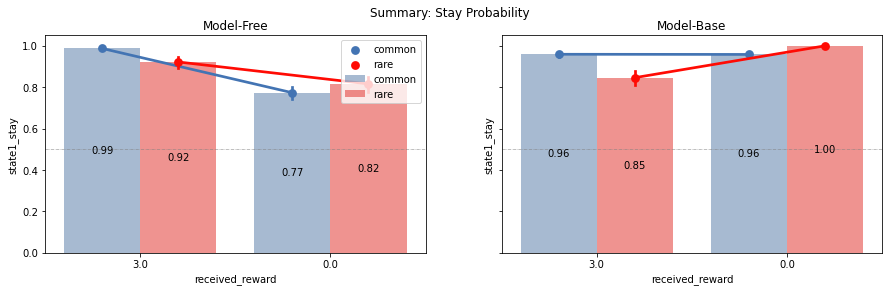

In [5]:
# Create an array with the colors you want to use
my_palette = sns.color_palette(["#4374B3", "#FF0B04"])

fig, axes = plt.subplots(1,2, figsize=(15,4), sharex=True, sharey=True)
fig.suptitle('Summary: Stay Probability')
sns.barplot(data=df1_state1stay, x='received_reward', y='state1_stay', 
            hue='state_frequency', 
            palette=my_palette, alpha=.5, 
            order = sorted(df1_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'], errorbar=None,
            ax=axes[0]) 
sns.pointplot(data=df1_state1stay, x='received_reward', y='state1_stay', dodge=0.4,
            hue='state_frequency', 
              palette=my_palette, 
            order = sorted(df1_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[0]) 

sns.barplot(data=df2_state1stay, x='received_reward', y='state1_stay',
            hue='state_frequency', palette=my_palette, alpha=.5,
            order = sorted(df2_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'], errorbar=None,
            ax=axes[1]) 
sns.pointplot(data=df2_state1stay, x='received_reward', y='state1_stay',  dodge=0.4,
            hue='state_frequency', 
            palette=my_palette, 
            order = sorted(df2_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[1])  

for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center')
    ax.axhline(0.5, color='grey', ls='-.', linewidth=.5)    

    

axes[0].legend(loc=1)
axes[1].legend_.remove()
axes[0].set_title('Model-Free')
axes[1].set_title('Model-Base')

plt.show()

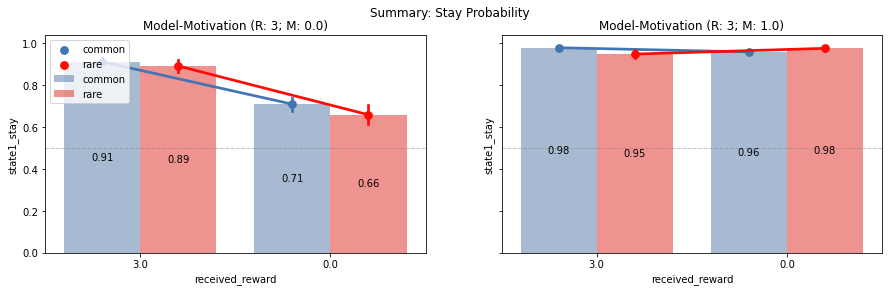

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15,4), sharex=True, sharey=True)
fig.suptitle('Summary: Stay Probability')
sns.barplot(data=df31_state1stay, x='received_reward', y='state1_stay',
            hue='state_frequency', palette=my_palette, alpha=.5,
            order = sorted(df31_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'], errorbar=None,
            ax=axes[0]) 
sns.pointplot(data=df31_state1stay, x='received_reward', y='state1_stay',  dodge=0.4,
            hue='state_frequency', 
            palette=my_palette, 
            order = sorted(df31_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[0]) 

sns.barplot(data=df32_state1stay, x='received_reward', y='state1_stay',
            hue='state_frequency', palette=my_palette, alpha=.5,
            order = sorted(df32_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'], errorbar=None,
            ax=axes[1]) 
sns.pointplot(data=df32_state1stay, x='received_reward', y='state1_stay',  dodge=0.4,
            hue='state_frequency', 
            palette=my_palette, 
            order = sorted(df32_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[1]) 

for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center')
    ax.axhline(0.5, color='grey', ls='-.', linewidth=.5)    

axes[0].legend(loc=2)
axes[1].legend_.remove() 
axes[0].set_title('Model-Motivation (R: %.d; M: %.1f)' % (df31['received_reward'].max(), df31['m_parameter'].max()))
axes[1].set_title('Model-Motivation (R: %.d; M: %.1f)' % (df32['received_reward'].max(), df32['m_parameter'].max()))

plt.show()


In [7]:
df1_state1stay_aggregate = df1_state1stay.groupby(['epoch', 'state_frequency', 'received_reward'])['state1_stay'].mean().reset_index()
df1_state1stay_aggregate.shape, df1_state1stay.shape

((40, 4), (3000, 12))

## Response Time

In [8]:
df1_long = df1[['received_reward', 'state_frequency', 'state1_response_time', 'state2_response_time']].melt(id_vars=['received_reward', 'state_frequency'], value_vars=['state1_response_time', 'state2_response_time'], var_name='state_name', value_name='response_time')
df2_long = df2[['received_reward', 'state_frequency', 'state1_response_time', 'state2_response_time']].melt(id_vars=['received_reward', 'state_frequency'], value_vars=['state1_response_time', 'state2_response_time'], var_name='state_name', value_name='response_time')
df31_long = df31[['received_reward', 'state_frequency', 'state1_response_time', 'state2_response_time']].melt(id_vars=['received_reward', 'state_frequency'], value_vars=['state1_response_time', 'state2_response_time'], var_name='state_name', value_name='response_time')
df32_long = df32[['received_reward', 'state_frequency', 'state1_response_time', 'state2_response_time']].melt(id_vars=['received_reward', 'state_frequency'], value_vars=['state1_response_time', 'state2_response_time'], var_name='state_name', value_name='response_time')


df1_long['state'] = df1_long.apply(lambda x: x['state_name'].split('_')[0]+':'+x['state_frequency'], axis=1)
df2_long['state'] = df2_long.apply(lambda x: x['state_name'].split('_')[0]+':'+x['state_frequency'], axis=1)
df31_long['state'] = df31_long.apply(lambda x: x['state_name'].split('_')[0]+':'+x['state_frequency'], axis=1)
df32_long['state'] = df32_long.apply(lambda x: x['state_name'].split('_')[0]+':'+x['state_frequency'], axis=1)

df31_long = df31_long.astype({'response_time':'float'})
df32_long = df32_long.astype({'response_time':'float'})

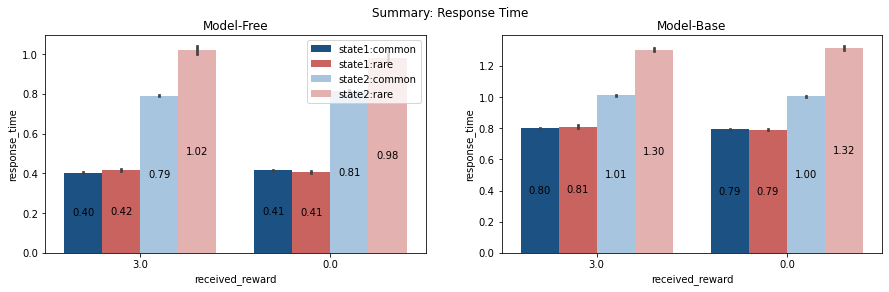

In [9]:
my_palette2 = sns.color_palette(["#0b5394", "#D9534F", "#9fc5e8", "#ECA9A7"])
hue_order = ['state1:common', 'state1:rare', 'state2:common', 'state2:rare']

fig, axes = plt.subplots(1,2, figsize=(15,4), sharex=True)
fig.suptitle('Summary: Response Time')
sns.barplot(data=df1_long, x='received_reward', y='response_time', 
            hue='state', palette=my_palette2,
            order = sorted(df1_long['received_reward'].unique(), reverse=True), 
            hue_order=hue_order, ax=axes[0]) 

sns.barplot(data=df2_long, x='received_reward', y='response_time',
            hue='state', palette=my_palette2,  
            order = sorted(df2_long['received_reward'].unique(), reverse=True), 
            hue_order=hue_order, ax=axes[1]) 
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center')    

axes[0].legend(loc=1)
axes[1].legend_.remove()
axes[0].set_title('Model-Free')
axes[1].set_title('Model-Base')

plt.show()

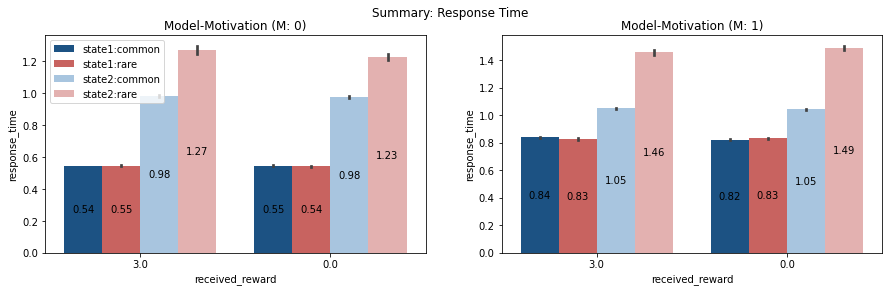

In [10]:
fig, axes = plt.subplots(1,2, figsize=(15,4), sharex=True)
fig.suptitle('Summary: Response Time')
sns.barplot(data=df31_long, x='received_reward', y='response_time', 
            hue='state', palette=my_palette2,
            order = sorted(df31_long['received_reward'].unique(), reverse=True), 
            hue_order=hue_order, ax=axes[0]) 

sns.barplot(data=df32_long, x='received_reward', y='response_time',
            hue='state', palette=my_palette2,  
            order = sorted(df32_long['received_reward'].unique(), reverse=True), 
            hue_order=hue_order, ax=axes[1]) 
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center')    

axes[0].legend(loc=2)
axes[1].legend_.remove() 
axes[0].set_title('Model-Motivation (M: %.d)' % (df31['m_parameter'].max()))
axes[1].set_title('Model-Motivation (M: %.d)' % (df32['m_parameter'].max()))

plt.show()

## Learning Performance

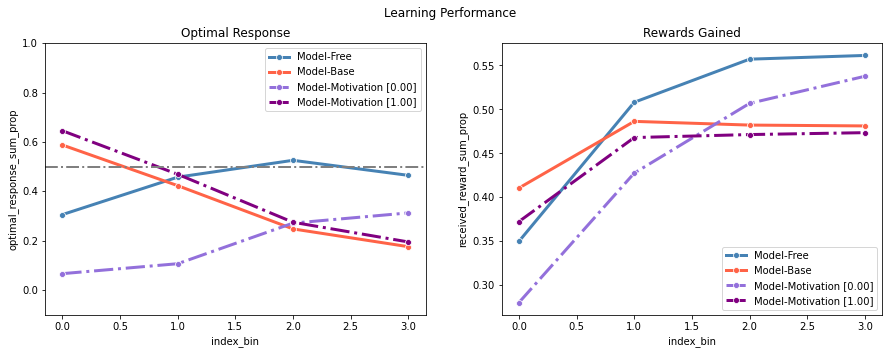

In [11]:
df1_aggregate  = df1.groupby(['index_bin']).agg(optimal_response_sum_prop=('optimal_response_sum_prop', 'mean'), received_reward_sum_prop=('received_reward_sum_prop', 'mean')).reset_index()
df2_aggregate  = df2.groupby(['index_bin']).agg(optimal_response_sum_prop=('optimal_response_sum_prop', 'mean'), received_reward_sum_prop=('received_reward_sum_prop', 'mean')).reset_index()
df31_aggregate  = df31.groupby(['index_bin']).agg(optimal_response_sum_prop=('optimal_response_sum_prop', 'mean'), received_reward_sum_prop=('received_reward_sum_prop', 'mean')).reset_index()
df32_aggregate  = df32.groupby(['index_bin']).agg(optimal_response_sum_prop=('optimal_response_sum_prop', 'mean'), received_reward_sum_prop=('received_reward_sum_prop', 'mean')).reset_index()

fig, axes = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Learning Performance')
# Optimal Responses
sns.lineplot(data=df1_aggregate, x='index_bin', y='optimal_response_sum_prop', label='Model-Free', color='steelblue', marker='o', lw=3, ax=axes[0])
sns.lineplot(data=df2_aggregate, x='index_bin', y='optimal_response_sum_prop', label='Model-Base', color='tomato', marker='o', lw=3, ax=axes[0])
sns.lineplot(data=df31_aggregate, x='index_bin', y='optimal_response_sum_prop', ls='-.', label='Model-Motivation [%.2f]' % (df31['m_parameter'].unique()), color='mediumpurple', marker='o', lw=3, ax=axes[0])
sns.lineplot(data=df32_aggregate, x='index_bin', y='optimal_response_sum_prop', ls='-.', label='Model-Motivation [%.2f]' % (df32['m_parameter'].unique()), color='purple', marker='o', lw=3, ax=axes[0])


sns.lineplot(data=df1_aggregate, x='index_bin', y='received_reward_sum_prop', label='Model-Free', color='steelblue', marker='o', lw=3, ax=axes[1])
sns.lineplot(data=df2_aggregate, x='index_bin', y='received_reward_sum_prop', label='Model-Base', color='tomato', marker='o', lw=3, ax=axes[1])
sns.lineplot(data=df31_aggregate, x='index_bin', y='received_reward_sum_prop', ls='-.', label='Model-Motivation [%.2f]' % (df31['m_parameter'].unique()), color='mediumpurple', marker='o', lw=3, ax=axes[1])
sns.lineplot(data=df32_aggregate, x='index_bin', y='received_reward_sum_prop', ls='-.', label='Model-Motivation [%.2f]' % (df32['m_parameter'].unique()), color='purple', marker='o', lw=3, ax=axes[1])


axes[0].axhline(0.5, color='grey', ls='-.', linewidth=2)
axes[0].set_ylim(-0.1,1)
axes[0].set_title('Optimal Response')
axes[1].set_title('Rewards Gained')

plt.show()

## Reward Probability